# Rolling Planning mit Flow Time

In [1]:
import time

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 20)

In [3]:
import utils.presenter as show
import utils.checker as check

import utils.scheduling_solver as ssv

from ProductionDaySimulation import ProductionDaySimulation

In [4]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced

## Generierung des Datensatzes für 10 Tage (Ankunft)

In [5]:
df_instance = pd.read_csv("data/00_instance.csv")

df_jssp, df_times = rp_init.init_jobs_with_arrivals(df_instance, 10,  u_b_mmax = 0.95)
df_jssp

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
1895,Job_189,5,M9,76
1896,Job_189,6,M5,47
1897,Job_189,7,M3,52
1898,Job_189,8,M4,90


In [6]:
df_times

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.42
2,Job_002,144.74
3,Job_003,197.03
4,Job_004,233.63
...,...,...
185,Job_185,14088.21
186,Job_186,14094.27
187,Job_187,14095.63
188,Job_188,14214.35


## Params

In [7]:
max_time = 60*60*6 # 6h

In [8]:
# fix
day_length = 1440
horizon_days = 3

In [9]:
# init
day_numb = 0

day_start = 0
day_end = 0
planning_end = 0

# Initialisierung (Tag 0)

In [10]:
day_numb = 0

In [11]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440
planning_end =  day_start + horizon_days*day_length  # 4320

In [12]:
# I)
df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
df_jssp_curr

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
565,Job_056,5,M9,76
566,Job_056,6,M5,47
567,Job_056,7,M3,52
568,Job_056,8,M4,90


In [13]:
df_times_curr 

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.42
2,Job_002,144.74
3,Job_003,197.03
4,Job_004,233.63
...,...,...
52,Job_052,4008.21
53,Job_053,4014.27
54,Job_054,4015.63
55,Job_055,4134.35


### Scheduling

In [14]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_jssp_flowtime(df_jssp_curr, df_times_curr, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.10)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 34000

Solver-Informationen:
  Summe Flow Times        : 61506.56
  Solver-Status           : Optimal
  Anzahl Variablen        : 16587
  Anzahl Constraints      : 32490

Scheduling-Dauer: 360 Minuten und 0.92 Sekunden.


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29.0,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78.0,107.00,107.00
2,Job_001,0,83.42,M0,83.42,43.0,43.00,126.42
3,Job_000,2,0.00,M2,107.00,9.0,116.00,116.00
4,Job_000,3,0.00,M3,116.00,36.0,152.00,152.00
...,...,...,...,...,...,...,...,...
565,Job_055,7,4134.35,M7,5673.21,56.0,1594.86,5729.21
566,Job_052,8,4008.21,M9,5726.21,22.0,1740.00,5748.21
567,Job_055,8,4134.35,M8,5729.21,44.0,1638.86,5773.21
568,Job_052,9,4008.21,M5,5748.21,43.0,1783.00,5791.21


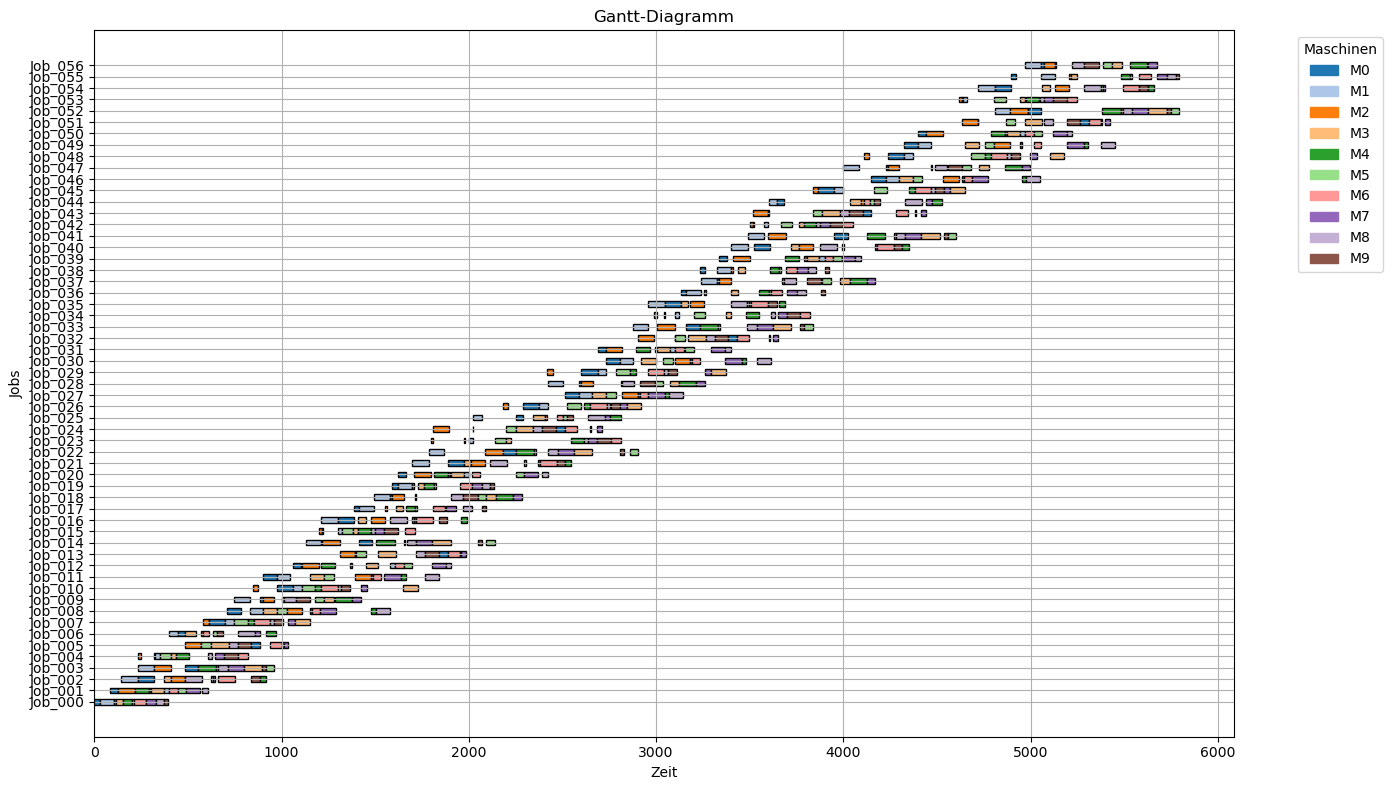

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [15]:
show.plot_gantt_jobs(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

### Simulation

In [16]:
simulation = ProductionDaySimulation(df_plan, vc=0.35)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:23:25] Job_001 started on M0
[01:24:39] Job_000 finished on M1 (after 55 minutes 39 seconds)
[01:47:00] Job_000 started on M2
[01:58:45] Job_001 finished on M0 (after 35 minutes 20 seconds)
[01:59:22] Job_000 finished on M2 (after 12 minutes 22 seconds)
[01:59:22] Job_000 started on M3
[02:06:25] Job_001 started on M2
[02:24:44] Job_002 started on M1
[02:30:39] Job_000 finished on M3 (after 31 minutes 17 seconds)
[02:32:00] Job_000 started on M4
[03:35:40] Job_000 finished on M4 (after 63 minutes 40 seconds)
[03:35:40] Job_000 started on M5
[03:44:46] Job_000 finished on M5 (after 09 minutes 06 seconds)
[03:44:46] Job_000 started on M6
[04:01:58] Job_002 finished on M1 (after 97 minutes 14 seconds)
[04:01:58] Job_003 started on M1
[04:01:58] Job_002 started on M0
[04:20:17] Job_001 finished on M2 (after 133 minutes 52 seconds)
[04:20:17] Job_004 started 

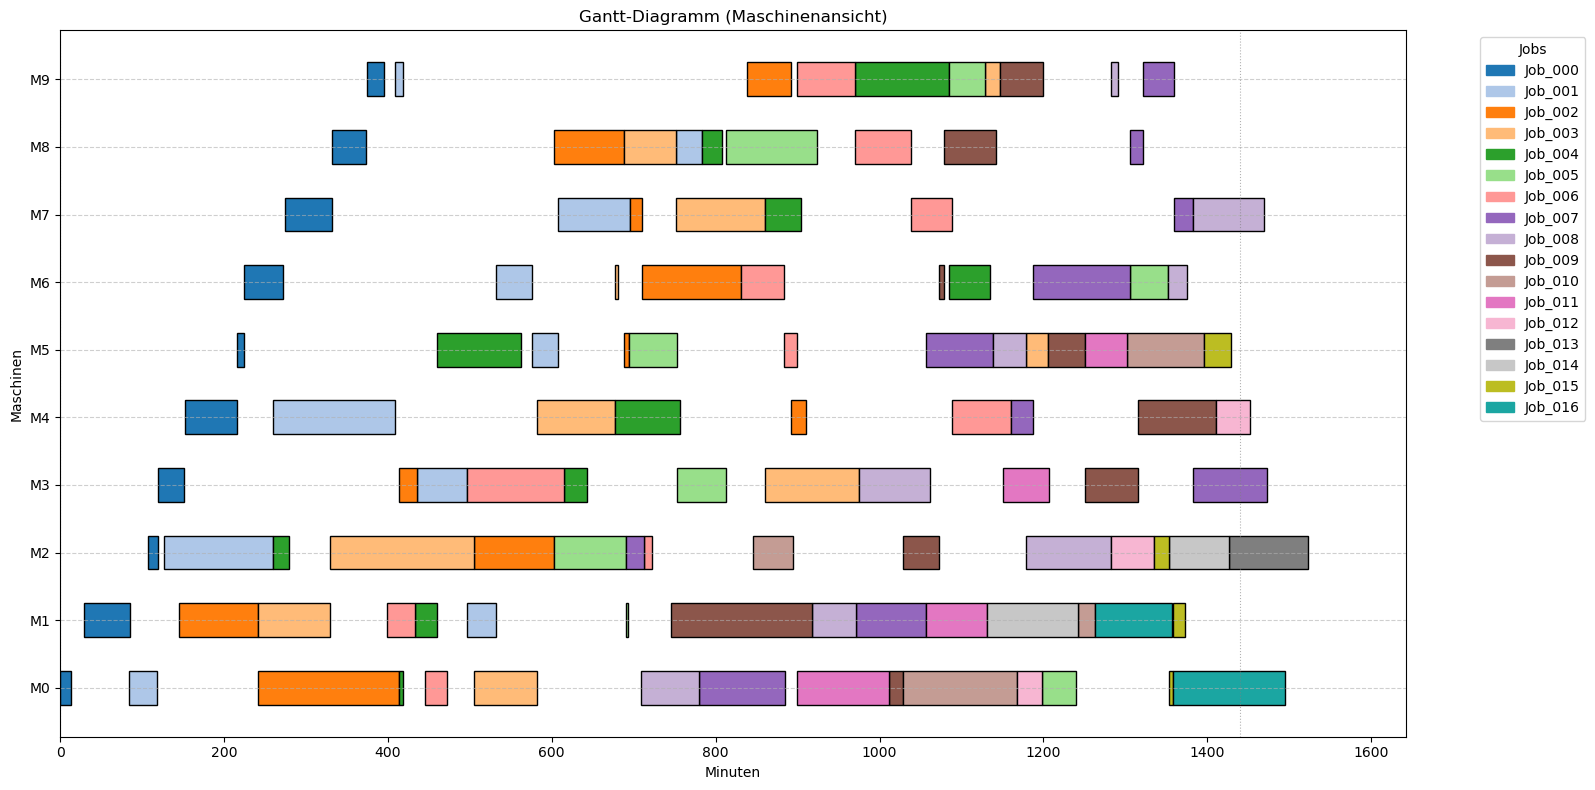

In [17]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

In [20]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_005,8,302.58,M4,1004.74,6.0
1,Job_005,9,302.58,M7,1010.74,25.0
2,Job_010,4,845.00,M4,1180.74,32.0
3,Job_010,5,845.00,M6,1212.74,88.0
4,Job_010,6,845.00,M8,1300.74,19.0
...,...,...,...,...,...,...
450,Job_055,7,4134.35,M7,5673.21,56.0
451,Job_052,8,4008.21,M9,5726.21,22.0
452,Job_055,8,4134.35,M8,5729.21,44.0
453,Job_052,9,4008.21,M5,5748.21,43.0


#### Export

In [18]:
df_jssp.to_csv("data/05_flowtime_all_jssp.csv", index = False)
df_times.to_csv("data/05_flowtime_all_times.csv", index = False)

In [19]:
df_plan.to_csv("data/05_flowtime_init_plan.csv", index = False)
df_execution.to_csv("data/05_flowtime_execution.csv", index = False)
df_undone.to_csv("data/05_flowtime_init_undone.csv", index = False)